In [1]:
import numpy as np
import pandas as pd
import pandas_profiling
from tqdm import tqdm
import tensorflow as tf
import time 
import warnings
warnings.filterwarnings("ignore")
import os
import sys
import seaborn as sns
import matplotlib.pyplot as plt
import math
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
FOLDERNAME = 'TNT_VISION'
assert FOLDERNAME is not None, "[!] Enter the foldername."
import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

%cd /content/drive/My\ Drive/$FOLDERNAME

Mounted at /content/drive
/content/drive/My Drive/TNT_VISION


In [2]:
filepath = "LSWMD.pkl"
df=pd.read_pickle(filepath)

In [3]:
data = df.iloc[:,[0,1,4,5]]
data

,waferMap,dieSize,trianTestLabel,failureType
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,[[Training]],[[none]]
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,[[Training]],[[none]]
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,[[Training]],[[none]]
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,[[Training]],[[none]]
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,[[Training]],[[none]]
...,...,...,...,...
811452,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1,...",600.0,[[Test]],[[Edge-Ring]]
811453,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 1, 1,...",600.0,[[Test]],[[Edge-Loc]]
811454,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1,...",600.0,[[Test]],[[Edge-Ring]]
811455,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,...",600.0,[],[]


In [4]:
failtype = ['Center', 'Donut', 'Edge-Loc', 'Edge-Ring', 'Loc', 'Random', 'Scratch', 'Near-full','none']
labeltype = ['Training', 'Test']
data['FAILTYPE'] = '0'
data['LABEL'] = '0'

for tp in failtype:
  data.loc[data['failureType'] == tp,'FAILTYPE'] = tp
data = data.loc[(data.FAILTYPE!= '0')].drop('failureType', axis = 1)

for tp in labeltype:
  data.loc[data['trianTestLabel'] == tp,'LABEL'] = tp
data = data.loc[(data.LABEL != '0')].drop('trianTestLabel', axis = 1).reset_index(drop = True)

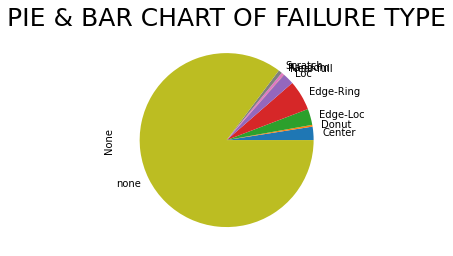

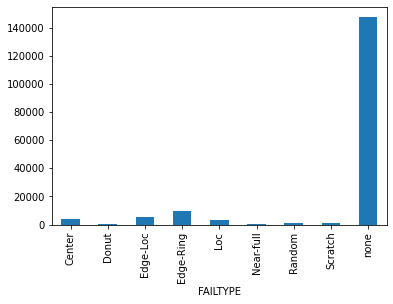

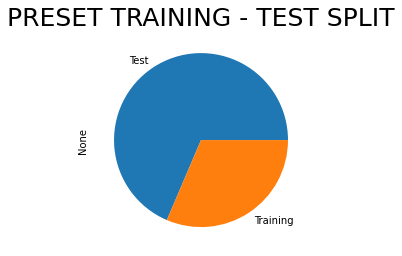

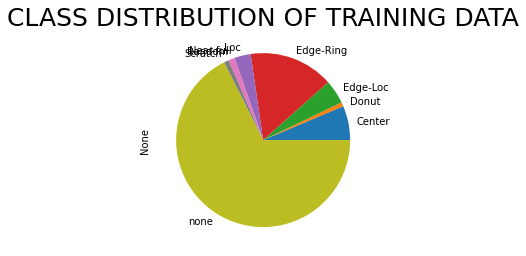

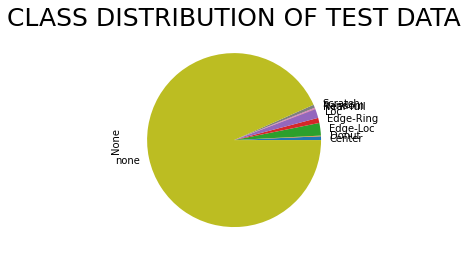

In [5]:
data.groupby("FAILTYPE").size().plot.pie()
plt.title('PIE & BAR CHART OF FAILURE TYPE', fontdict = {'fontsize' : 25})
plt.show()
data.groupby("FAILTYPE").size().plot.bar()
plt.show()
print('\n')
data.groupby("LABEL").size().plot.pie()
plt.title("PRESET TRAINING - TEST SPLIT", fontdict = {'fontsize' : 25})
plt.show()
data.loc[(data["LABEL"] == "Training"),:].groupby("FAILTYPE").size().plot.pie()
plt.title("CLASS DISTRIBUTION OF TRAINING DATA", fontdict = {'fontsize' : 25})
plt.show()
data.loc[(data["LABEL"] == "Test"),:].groupby("FAILTYPE").size().plot.pie()
plt.title("CLASS DISTRIBUTION OF TEST DATA", fontdict = {'fontsize' : 25})
plt.show()
## PRESET data split is meaningless!

In [6]:
data = data.drop('LABEL',axis = 1).drop('dieSize', axis = 1)

In [7]:
import cv2
def cubic_resize(x):
  resized_x = cv2.resize(x, dsize=(width, width), interpolation=cv2.INTER_CUBIC) # BICUBIC INTERPOLATION
  # 이미지 확대 시에는 바이큐빅 / 선형 보간을 사용하는게 효과가 좋다. 
  return resized_x

def linear_resize(x):
  resized_x = cv2.resize(x, dsize=(width, width), interpolation=cv2.INTER_AREA) # LINEAR INTERPOLATION
  return resized_x

def find_dim(x):
    dim0=np.size(x,axis=0)
    dim1=np.size(x,axis=1)
    return dim0,dim1

def vis(x,y,z, label):
  fig = plt.figure(figsize=(8, 24))
  
  ax1 = fig.add_subplot(1, 3, 1)
  ax2 = fig.add_subplot(1, 3, 2)
  ax3 = fig.add_subplot(1, 3, 3)
  ax1.matshow(x)
  ax1.axis("off")
  ax1.set_title("Original of " + str(label))
  ax2.matshow(y)
  ax2.axis("off")
  ax2.set_title("Linear of " + str(label))
  ax3.matshow(z)
  ax3.axis("off")
  ax3.set_title("Cubic of " + str(label))
  plt.show()

data['waferMapDim']=data.waferMap.apply(find_dim)

In [8]:
data.groupby("waferMapDim").size().sort_values(ascending=False)[:20]
# size는 32 * 32 가 좋겠어.
width = 48

In [9]:
data['linear_resized_wafer']=data.waferMap.apply(linear_resize)
data['cubic_resized_wafer']=data.waferMap.apply(cubic_resize)

In [10]:
data

,waferMap,FAILTYPE,waferMapDim,linear_resized_wafer,cubic_resized_wafer
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",none,"(45, 48)","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",none,"(45, 48)","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",none,"(45, 48)","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",none,"(45, 48)","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",none,"(45, 48)","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
...,...,...,...,...,...
172945,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 2,...",Edge-Loc,"(26, 30)","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
172946,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,...",Edge-Loc,"(26, 30)","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
172947,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1,...",Edge-Ring,"(26, 30)","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
172948,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 1, 1,...",Edge-Loc,"(26, 30)","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."


In [11]:
number_of_sample = 15
sample = data.sample(number_of_sample)
WAFER = sample.waferMap.values
LINEAR = sample.linear_resized_wafer.values
CUBIC = sample.cubic_resized_wafer.values
LB = sample.FAILTYPE.values

In [12]:
images = data.cubic_resized_wafer.values
labels = data.FAILTYPE.values
X = np.zeros((len(images), width, width))
for i in range(len(images)):
  X[i,:,:] = images[i]
X = X.reshape((-1, width , width , 1))
print(X.shape)
print(labels.shape)

(172950, 48, 48, 1)
(172950,)


In [13]:
NONE = data.loc[(data.FAILTYPE == 'none'),:].sample(10000)
data.drop(data[data.FAILTYPE == 'none'].index, inplace = True)
print(NONE.shape)
print(data.shape)

(10000, 5)
(25519, 5)


In [14]:
data = pd.concat([data, NONE], ignore_index=True)

In [15]:
images = data.cubic_resized_wafer.values
labels = data.FAILTYPE.values
X = np.zeros((len(images), width, width))
for i in range(len(images)):
  X[i,:,:] = images[i]
X = X.reshape((-1, width, width, 1))
print(X.shape)
print(labels.shape)

(35519, 48, 48, 1)
(35519,)


In [16]:
faulty_case = np.unique(labels)
faulty_case_dict =dict()
for i, f in enumerate(faulty_case) :
    print('{} : {}'.format(f, len(labels[labels==f])))
    faulty_case_dict[i] = f

Center : 4294
Donut : 555
Edge-Loc : 5189
Edge-Ring : 9680
Loc : 3593
Near-full : 149
Random : 866
Scratch : 1193
none : 10000


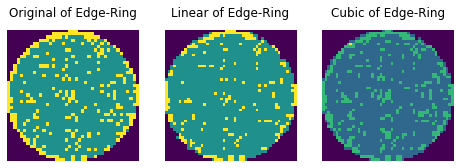

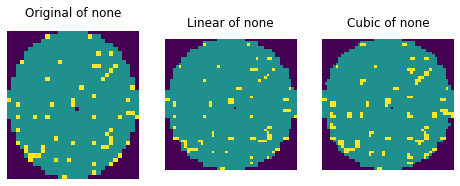

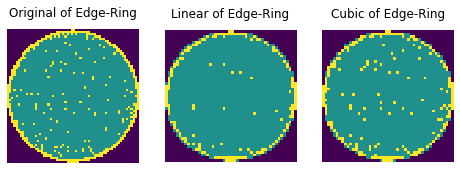

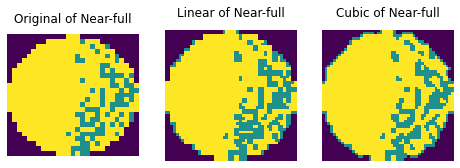

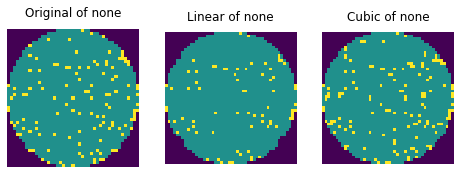

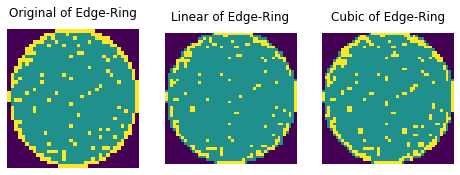

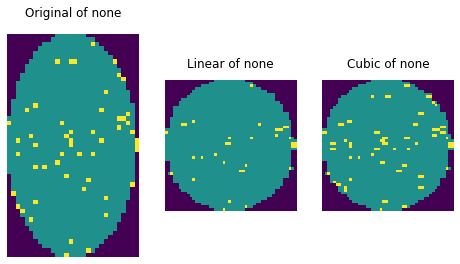

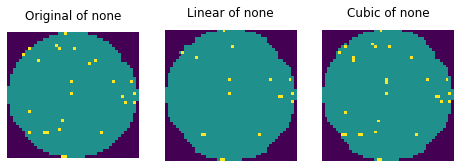

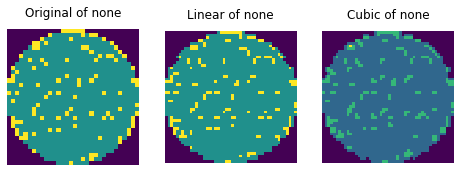

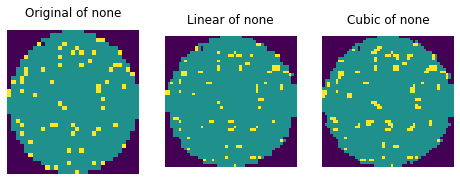

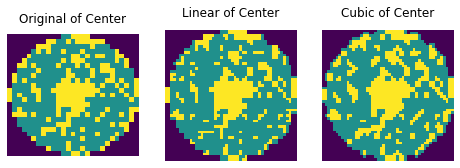

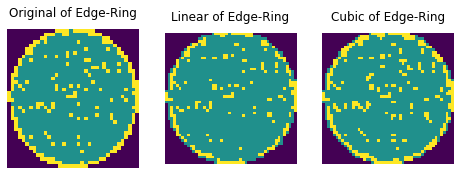

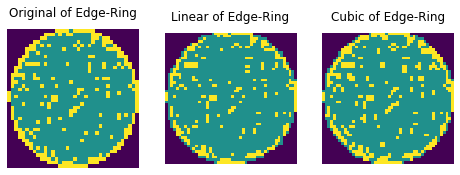

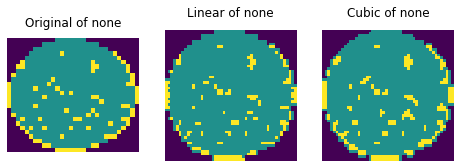

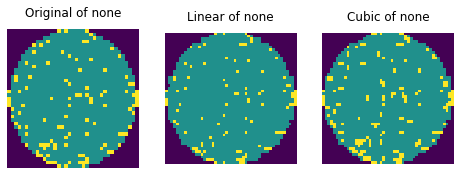

In [17]:
number_of_sample = 15
sample = data.sample(number_of_sample)
WAFER = sample.waferMap.values
LINEAR = sample.linear_resized_wafer.values
CUBIC = sample.cubic_resized_wafer.values
LB = sample.FAILTYPE.values
for i in range(number_of_sample):
  vis(WAFER[i], LINEAR[i], CUBIC[i], LB[i])

In [18]:
new_x = np.zeros((X.shape[0], width, width, 3))

for w in range(X.shape[0]):
    for i in range(width):
        for j in range(width):
            new_x[w, i, j, int(X[w, i, j])-1] = 1 # np where 로 최적화 가능할 듯

In [19]:
print(new_x.shape)

(35519, 48, 48, 3)


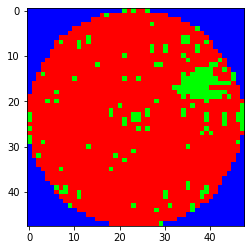

In [20]:
plt.imshow(new_x[0])
plt.show()

In [21]:
faulty_case = np.unique(labels)
faulty_case_dict =dict()
for i, f in enumerate(faulty_case) :
    print('{} : {}'.format(f, len(labels[labels==f])))
    faulty_case_dict[i] = f

Center : 4294
Donut : 555
Edge-Loc : 5189
Edge-Ring : 9680
Loc : 3593
Near-full : 149
Random : 866
Scratch : 1193
none : 10000


In [22]:
# train test split
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
encoder = LabelEncoder()
encoded_labels = encoder.fit_transform(labels)
x_train, x_test, y_train, y_test = train_test_split(new_x, labels, test_size=0.3, shuffle=True, stratify=encoded_labels, random_state=42)

In [23]:
#VAE
from tensorflow.keras import layers
from tensorflow import keras
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon
latent_dim = 2

encoder_inputs = keras.Input(shape=(48, 48, 3))
x = layers.Conv2D(16, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(64, activation="relu")(x)
x = layers.Dense(16, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 48, 48, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 24, 24, 16)   448         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 12, 12, 32)   4640        conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 6, 6, 64)     18496       conv2d_1[0][0]                   
____________________________________________________________________________________________

In [24]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(6 * 6 * 64, activation="relu")(latent_inputs)
x = layers.Reshape((6, 6, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(16, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(3, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
dense_2 (Dense)              (None, 2304)              6912      
_________________________________________________________________
reshape (Reshape)            (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 12, 12, 64)        36928     
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 24, 24, 32)        18464     
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 48, 48, 16)        4624      
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 48, 48, 3)         435 

In [25]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

In [26]:


#dt = np.expand_dims(dt, -1).astype("float32")

vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
hist = vae.fit(x_train, epochs=100, batch_size=64)

Epoch 1/100
389/389 [==============================] - 20s 7ms/step - loss: 914.4536 - reconstruction_loss: 678.7357 - kl_loss: 5.4432
Epoch 2/100
389/389 [==============================] - 3s 7ms/step - loss: 519.1997 - reconstruction_loss: 509.5253 - kl_loss: 3.7104
Epoch 3/100
389/389 [==============================] - 3s 7ms/step - loss: 497.1735 - reconstruction_loss: 491.7238 - kl_loss: 4.6064
Epoch 4/100
389/389 [==============================] - 3s 7ms/step - loss: 491.2368 - reconstruction_loss: 485.1235 - kl_loss: 4.6754
Epoch 5/100
389/389 [==============================] - 3s 7ms/step - loss: 486.4123 - reconstruction_loss: 479.8909 - kl_loss: 4.8349
Epoch 6/100
389/389 [==============================] - 3s 7ms/step - loss: 482.8202 - reconstruction_loss: 475.7119 - kl_loss: 5.0197
Epoch 7/100
389/389 [==============================] - 3s 7ms/step - loss: 476.6665 - reconstruction_loss: 472.1534 - kl_loss: 5.1365
Epoch 8/100
389/389 [==============================] - 3s 7ms

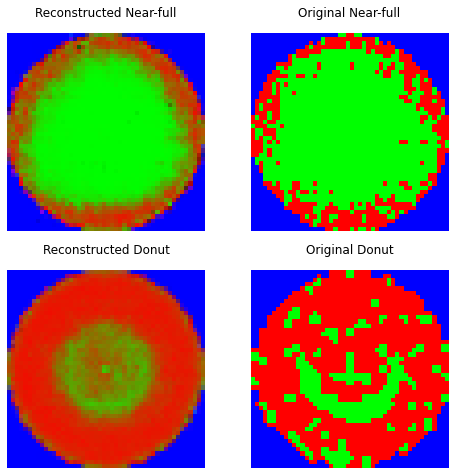

In [27]:
  fig = plt.figure(figsize=(8, 8))
  #
  hi = vae.encoder.predict(x_train[4410].reshape(-1,48,48,3))
  bye = (vae.decoder.predict(hi[2]) +  vae.decoder.predict(hi[0]))/2
  ax1 = fig.add_subplot(2, 2, 1)
  ax2 = fig.add_subplot(2, 2, 2)
  ax3 = fig.add_subplot(2, 2, 3)
  ax4 = fig.add_subplot(2, 2, 4)
  ax1.matshow(bye[0])
  ax1.axis("off")
  ax1.set_title("Reconstructed " + "Near-full")
  ax2.matshow(x_train[4410])
  ax2.axis("off")
  ax2.set_title("Original " + "Near-full")
  #
  hi = vae.encoder.predict(x_train[37].reshape(-1,48,48,3))
  bye = vae.decoder.predict((hi[2]  + hi[0])/2)
  plt.imshow(bye[0])
  ax3.matshow(bye[0])
  ax3.axis("off")
  ax3.set_title("Reconstructed " + "Donut")
  ax4.matshow(x_train[37])
  ax4.axis("off")
  ax4.set_title("Original " + "Donut")
  plt.show()

In [28]:
np.where(y_train == "Center")[0][:30]

array([ 10,  26,  27,  40,  46,  61,  71,  88,  92, 108, 112, 124, 134,
       136, 138, 143, 152, 153, 162, 169, 188, 190, 201, 202, 222, 223,
       244, 263, 267, 282])

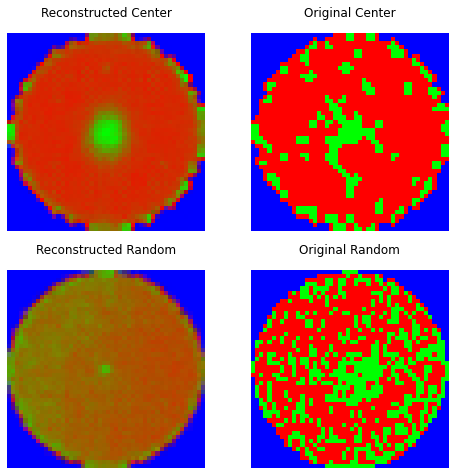

In [29]:
  fig = plt.figure(figsize=(8, 8))
  #
  hi = vae.encoder.predict(x_train[162].reshape(-1,48,48,3))
  bye = (vae.decoder.predict(hi[2]) +  vae.decoder.predict(hi[0]))/2
  ax1 = fig.add_subplot(2, 2, 1)
  ax2 = fig.add_subplot(2, 2, 2)
  ax3 = fig.add_subplot(2, 2, 3)
  ax4 = fig.add_subplot(2, 2, 4)
  ax1.matshow(bye[0])
  ax1.axis("off")
  ax1.set_title("Reconstructed " + "Center")
  ax2.matshow(x_train[162])
  ax2.axis("off")
  ax2.set_title("Original " + "Center")
  #
  hi = vae.encoder.predict(x_train[714].reshape(-1,48,48,3))
  bye = vae.decoder.predict((hi[2]  + hi[0])/2)
  plt.imshow(bye[0])
  ax3.matshow(bye[0])
  ax3.axis("off")
  ax3.set_title("Reconstructed " + "Random")
  ax4.matshow(x_train[714])
  ax4.axis("off")
  ax4.set_title("Original " + "Random")
  plt.show()

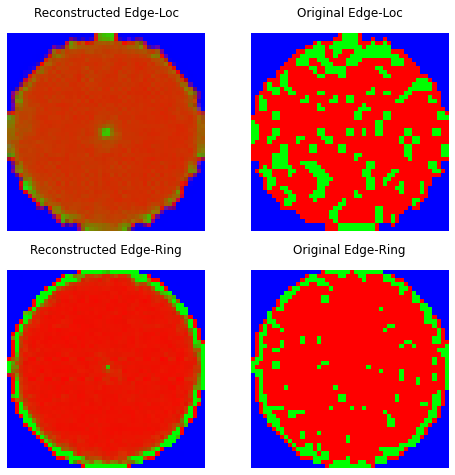

In [30]:
  fig = plt.figure(figsize=(8, 8))
  #
  hi = vae.encoder.predict(x_train[229].reshape(-1,48,48,3))
  bye = (vae.decoder.predict(hi[2]) +  vae.decoder.predict(hi[0]))/2
  ax1 = fig.add_subplot(2, 2, 1)
  ax2 = fig.add_subplot(2, 2, 2)
  ax3 = fig.add_subplot(2, 2, 3)
  ax4 = fig.add_subplot(2, 2, 4)
  ax1.matshow(bye[0])
  ax1.axis("off")
  ax1.set_title("Reconstructed " + "Edge-Loc")
  ax2.matshow(x_train[229])
  ax2.axis("off")
  ax2.set_title("Original " + "Edge-Loc")
  #
  hi = vae.encoder.predict(x_train[87].reshape(-1,48,48,3))
  bye = vae.decoder.predict((hi[2]  + hi[0])/2)
  plt.imshow(bye[0])
  ax3.matshow(bye[0])
  ax3.axis("off")
  ax3.set_title("Reconstructed " + "Edge-Ring")
  ax4.matshow(x_train[87])
  ax4.axis("off")
  ax4.set_title("Original " + "Edge-Ring")
  plt.show()

In [31]:
np.where(y_train == "Loc")[0][:30]

array([ 16,  36,  41,  62,  68,  69,  70,  77,  82,  83,  97, 106, 107,
       129, 130, 135, 137, 150, 157, 158, 160, 171, 195, 208, 217, 219,
       227, 228, 231, 236])

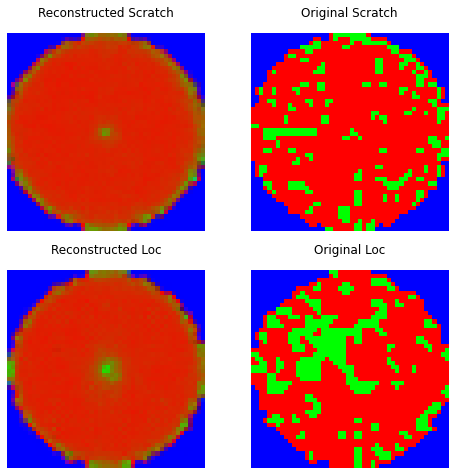

In [32]:
  fig = plt.figure(figsize=(8, 8))
  #
  hi = vae.encoder.predict(x_train[633].reshape(-1,48,48,3))
  bye = (vae.decoder.predict(hi[2]) +  vae.decoder.predict(hi[0]))/2
  ax1 = fig.add_subplot(2, 2, 1)
  ax2 = fig.add_subplot(2, 2, 2)
  ax3 = fig.add_subplot(2, 2, 3)
  ax4 = fig.add_subplot(2, 2, 4)
  ax1.matshow(bye[0])
  ax1.axis("off")
  ax1.set_title("Reconstructed " + "Scratch")
  ax2.matshow(x_train[633])
  ax2.axis("off")
  ax2.set_title("Original " + "Scratch")
  #
  hi = vae.encoder.predict(x_train[219].reshape(-1,48,48,3))
  bye = vae.decoder.predict((hi[2]  + hi[0])/2)
  plt.imshow(bye[0])
  ax3.matshow(bye[0])
  ax3.axis("off")
  ax3.set_title("Reconstructed " + "Loc")
  ax4.matshow(x_train[219])
  ax4.axis("off")
  ax4.set_title("Original " + "Loc")
  plt.show()

In [33]:
def rounded_accuracy(y_true, y_pred):
    return keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))
conv_encoder = keras.models.Sequential([
  keras.layers.Reshape([width,width,3], input_shape = [width,width,3]),                                      
  keras.layers.Conv2D(16, kernel_size = 3, padding = 'same', activation = 'selu'),
  keras.layers.MaxPool2D(pool_size = 2),
  keras.layers.Conv2D(32, kernel_size = 3, padding = 'same', activation = 'selu'),
  keras.layers.MaxPool2D(pool_size = 2),
  keras.layers.Conv2D(64, kernel_size = 3, padding = 'same', activation = 'selu'),
  keras.layers.MaxPool2D(pool_size = 2)
])
conv_decoder = keras.models.Sequential([
  keras.layers.Conv2DTranspose(32, kernel_size = 3, padding = 'same', activation = 'selu', strides = 2, input_shape = [6,6,64]),
  keras.layers.Conv2DTranspose(16, kernel_size = 3, padding = 'same', activation = 'selu', strides = 2),
  keras.layers.Conv2DTranspose(3, kernel_size = 3, padding = 'same', activation = 'sigmoid', strides = 2),
  keras.layers.Reshape([width,width,3]) 
])
conv_encoder.compile

Convolutional_AutoEncoder = keras.models.Sequential([conv_encoder, conv_decoder])
Convolutional_AutoEncoder.compile(loss="binary_crossentropy",
                   optimizer='adam', metrics=[rounded_accuracy])
Convolutional_AutoEncoder.summary()
Convolutional_AutoEncoder.fit(x_train, x_train, epochs = 10, shuffle = True)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 6, 6, 64)          23584     
_________________________________________________________________
sequential_1 (Sequential)    (None, 48, 48, 3)         23523     
Total params: 47,107
Trainable params: 47,107
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
777/777 [==============================] - 4s 4ms/step - loss: 0.2032 - rounded_accuracy: 0.9152
Epoch 2/10
777/777 [==============================] - 3s 4ms/step - loss: 0.1518 - rounded_accuracy: 0.9356
Epoch 3/10
777/777 [==============================] - 3s 4ms/step - loss: 0.1347 - rounded_accuracy: 0.9424
Epoch 4/10
777/777 [==============================] - 3s 4ms/step - loss: 0.1244 - rounded_accuracy: 0.9468
Epoch 5/10
777/777 [==============================] - 3s 4ms/step - loss: 0.1173

In [34]:
# augment function define
def vae_gen_data(wafer, label, AutoEncoder):
  encoder, decoder = AutoEncoder.layers

  encoded_x = encoder.predict(wafer)
  gen_x = np.zeros((1, width, width, 3))
  for i in range((6000//len(wafer))):
    noised_encoded_x = encoded_x + np.random.normal(loc=0, scale=0.1, size = (len(encoded_x),wafer.shape[0], 2))
    noised_encoded_x = (noised_encoded_x[0] + noised_encoded_x[2])/2
    noised_gen_x = decoder.predict(noised_encoded_x)
    gen_x = np.concatenate((gen_x, noised_gen_x), axis=0)
  gen_y = np.full((len(gen_x)), label)
  return gen_x[1:], gen_y[1:]

In [35]:
def cae_gen_data(wafer, label, AutoEncoder):
  encoder, decoder = AutoEncoder.layers
  encoded_x = encoder.predict(wafer)
  gen_x = np.zeros((1, width, width, 3))

  for i in range((6000//len(wafer))):
    noised_encoded_x = encoded_x + np.random.normal(loc=0, scale=0.1, size = (len(encoded_x), 6, 6, 64)) 
    noised_gen_x = decoder.predict(noised_encoded_x)
    gen_x = np.concatenate((gen_x, noised_gen_x), axis=0)
  gen_y = np.full((len(gen_x)), label)
    
  return gen_x[1:], gen_y[1:]

In [36]:
encoder, decoder = vae.layers
encoded_x = encoder.predict(x_train[np.where(y_train=='Donut')[0]])
print(f)
gen_x = np.zeros((1, width, width, 3))
for i in range((4000//len(x_train[np.where(y_train=='Donut')[0]]))):
  noised_encoded_x = encoded_x + np.random.normal(loc=0, scale=0.1, size = (len(encoded_x),x_train[np.where(y_train=='Donut')[0]].shape[0], 2))
  noised_encoded_x = (noised_encoded_x[0] + noised_encoded_x[2])/2
  noised_gen_x = decoder.predict(noised_encoded_x)
  gen_x = np.concatenate((gen_x, noised_gen_x), axis=0)
gen_y = np.full((len(gen_x)), "Donut")

none


In [37]:
X_train = x_train.astype(np.float32)

In [38]:
for f in faulty_case : 
    if f == 'none' : 
        continue
    
    
    elif f == "Scratch" or f == "Loc" or f == "Random" or  f == "Edge-Loc" : 
      gen_x, gen_y = cae_gen_data(X_train[np.where(y_train==f)[0]], f, Convolutional_AutoEncoder)
    else: 
      gen_x, gen_y = vae_gen_data(X_train[np.where(y_train==f)[0]], f, vae)

    y_train = np.concatenate((y_train, gen_y))
    X_train = np.concatenate((X_train, gen_x), axis=0)
    

In [39]:
X_train.shape

(59593, 48, 48, 3)

In [40]:
y_train.shape

(59593,)

In [41]:
faulty_case = np.unique(y_train)
faulty_case_dict =dict()
print("Train dataset")
for i, f in enumerate(faulty_case) :
    print('{} : {}'.format(f, len(y_train[y_train==f])))
    faulty_case_dict[i] = f

Train dataset
Center : 6012
Donut : 6224
Edge-Loc : 7264
Edge-Ring : 6776
Loc : 7545
Near-full : 6032
Random : 6060
Scratch : 6680
none : 7000


In [42]:
faulty_case = np.unique(y_test)
faulty_case_dict =dict()
print("Test dataset")
for i, f in enumerate(faulty_case) :
    print('{} : {}'.format(f, len(y_test[y_test==f])))
    faulty_case_dict[i] = f

Test dataset
Center : 1288
Donut : 166
Edge-Loc : 1557
Edge-Ring : 2904
Loc : 1078
Near-full : 45
Random : 260
Scratch : 358
none : 3000


In [43]:
y_train

array(['Edge-Ring', 'Edge-Ring', 'none', ..., 'Scratch', 'Scratch',
       'Scratch'], dtype=object)

In [44]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
encoded_labels_train = encoder.fit_transform(y_train)
encoded_labels_test = encoder.fit_transform(y_test)

In [45]:
x_train, x_valid, y_train, y_valid = train_test_split(X_train, encoded_labels_train, test_size=0.2, shuffle=True, stratify=y_train, random_state=42)


In [46]:
batch_size = 64
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(100000).batch(batch_size, drop_remainder = True).prefetch(1)
valid_dataset = tf.data.Dataset.from_tensor_slices((x_valid, y_valid)).shuffle(100000).batch(batch_size, drop_remainder = True).prefetch(1)

callbacks = [tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=4, verbose=0,
    mode='auto', min_delta=0.0001, cooldown=0, min_lr=0
),
tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=6, verbose=0,
    mode='auto', baseline=None, restore_best_weights=True
)]

In [47]:
classifier = keras.models.Sequential([
  keras.layers.Conv2D(32,3,activation = 'relu', padding = 'same', kernel_initializer = 'he_normal', kernel_regularizer=tf.keras.regularizers.L2(l2=0.0001),
                      input_shape = [width,width,3]),
  keras.layers.MaxPool2D(2),
  keras.layers.Conv2D(64,3,activation = 'relu', kernel_initializer = 'he_normal', padding = 'same', kernel_regularizer=tf.keras.regularizers.L2(l2=0.0001)),
  keras.layers.MaxPool2D(2),
  keras.layers.Conv2D(128,3,activation = 'relu', kernel_initializer = 'he_normal',  padding = 'same', kernel_regularizer=tf.keras.regularizers.L2(l2=0.0001)),
  
  keras.layers.Flatten(),
  keras.layers.Dropout(0.5),
  keras.layers.Dense(256, activation = 'relu', kernel_initializer = 'he_normal', kernel_regularizer=tf.keras.regularizers.L2(l2=0.0001)),
  keras.layers.Dropout(0.5),
  keras.layers.Dense(9, activation = 'softmax')
])
classifier.compile(loss="sparse_categorical_crossentropy", optimizer='adam', metrics='accuracy')
classifier.summary()
history = classifier.fit(train_dataset, epochs = 50, validation_data=valid_dataset, callbacks = callbacks )

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 48, 48, 32)        896       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 24, 24, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 12, 12, 128)       73856     
_________________________________________________________________
flatten_1 (Flatten)          (None, 18432)             0         
_________________________________________________________________
dropout (Dropout)            (None, 18432)            

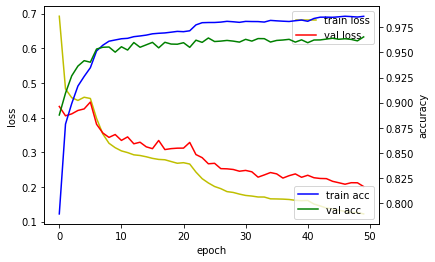

In [48]:
fig, loss_ax = plt.subplots()
acc_ax = loss_ax.twinx()
hist = history
loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='rigth')

acc_ax.plot(hist.history['accuracy'], 'b', label='train acc')
acc_ax.plot(hist.history['val_accuracy'], 'g', label='val acc')
acc_ax.set_ylabel('accuracy')
acc_ax.legend(loc='left')

plt.show()

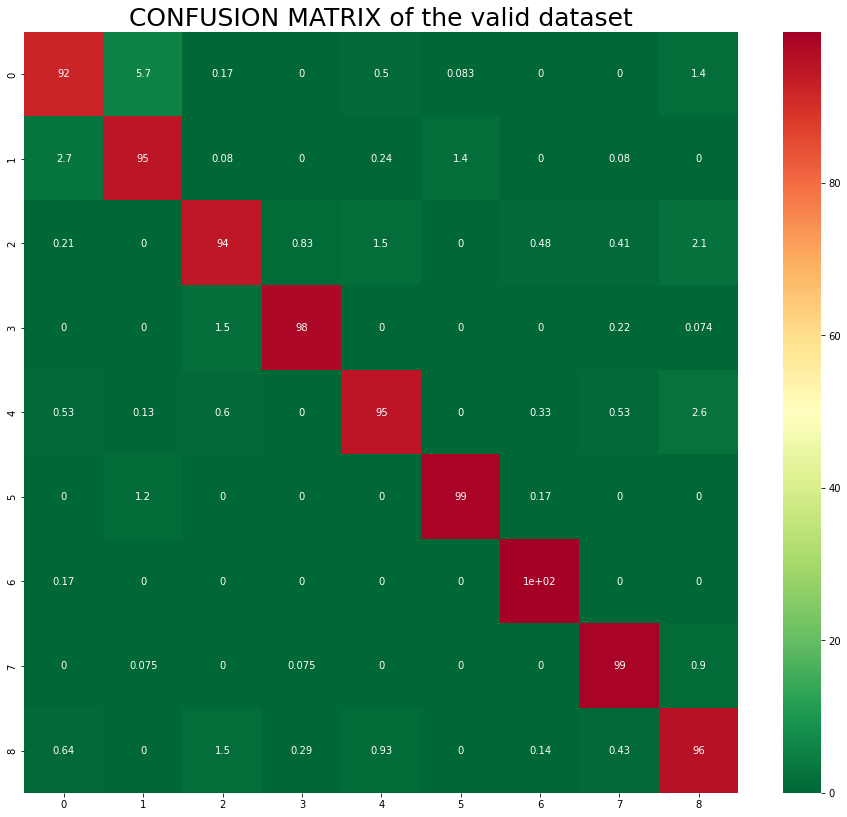

In [49]:
from sklearn.metrics import confusion_matrix
y_true = y_valid
y_pred = classifier.predict(x_valid)
plt.figure(figsize=(16,14))
sns.heatmap(confusion_matrix(encoder.inverse_transform(y_true), 
                             encoder.inverse_transform(y_pred.argmax(axis=1)), 
                             normalize = 'true')*100, annot = True, cmap='RdYlGn_r')
plt.title("CONFUSION MATRIX of the valid dataset", fontsize=25)
plt.show()

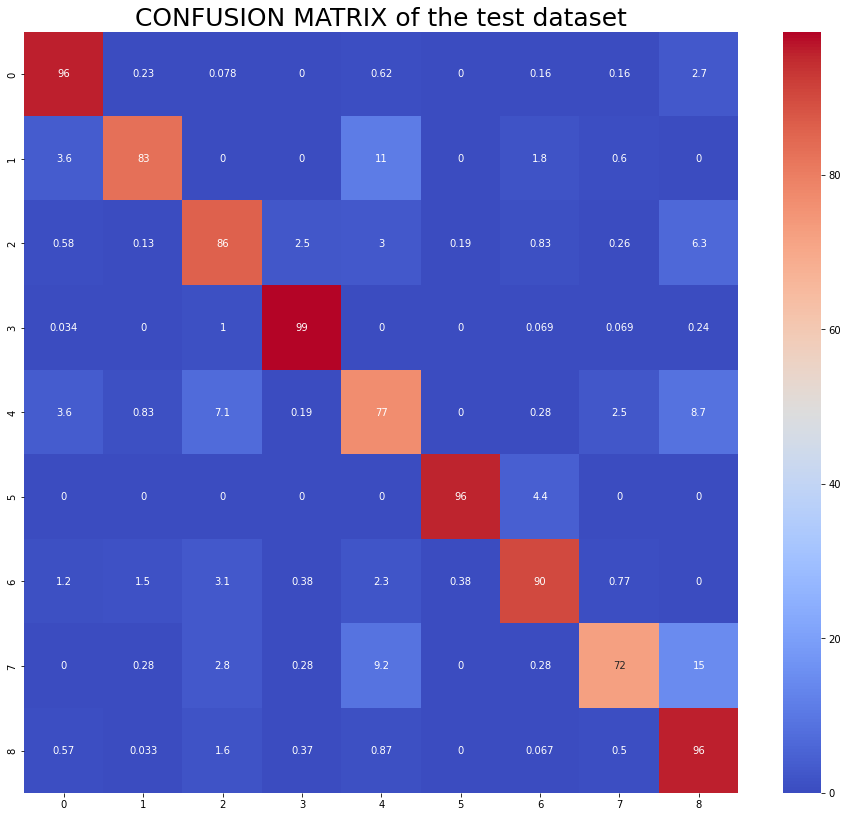

In [50]:
y_true = encoded_labels_test
y_pred = classifier.predict(x_test)
plt.figure(figsize=(16,14))
sns.heatmap(confusion_matrix(encoder.inverse_transform(y_true), 
                             encoder.inverse_transform(y_pred.argmax(axis=1)), 
                             normalize = 'true')*100, annot = True, cmap='coolwarm')
plt.title("CONFUSION MATRIX of the test dataset", fontsize=25)
plt.show()

In [51]:
from sklearn.metrics import f1_score
f1_score(y_true, y_pred.argmax(axis=1), average = None)
# MUCH BETTER THAN THE BASELINE MODEL
# MORE AUGMENTED, MORE OVERFITTED!!!

array([0.95153846, 0.85185185, 0.87312947, 0.98350515, 0.80959373,
       0.93478261, 0.89866157, 0.77313433, 0.93383068])